In [1]:
# Needed libraries 

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.actions.action_builder import ActionBuilder
from selenium.webdriver.common.actions.key_input import KeyInput
from selenium.webdriver.common.actions.pointer_input import PointerInput

# System requiremenmts 
import time
import random
import datetime as dt

# Data Management 
import pandas as pd

# Web scrapping functions 
import src.web_minning as wm

from shapely.geometry import Point
import geopandas as gpd

In [2]:
# Parameters 

CITY = "cdmx"
TAGS_LIST = wm.city_hashtags(CITY)
MAX_DEPTH = 5 # Iteration loop over each initial video
#MAX_SCROLLING = #

RAW_DATA = "./data/raw/"
ROOT_FILE = "root_links.csv"
DAY_FILE = f"day_file_{CITY}_2026-01-09.csv"
DAYS_FRESHNESS = 300

# Mexico City (CDMX) bounding box
# Format: (min_lat, min_lon, max_lat, max_lon)
CITY_BBOX = (
    19.0000,   # min_lat (south)
    -99.3600,  # min_lon (west)
    19.6000,   # max_lat (north)
    -98.9400   # max_lon (east)
)


In [33]:
# -----------------------
# Example Spanish presets
# -----------------------

PLACE_ADJ_JUNK = r"(?:bonit[oa]s?|lind[oa]s?|hermos[oa]s?|preci[oó]s[oa]s?|bell[oa]s?|encantador(?:a|es)?|espectacular(?:es)?|incre[ií]ble(?:s)?|maravillos[oa]s?|impresionante(?:s)?|perfect[oa]s?|m[aá]gic[oa]s?|grande(?:s)?|enorme(?:s)?|gigante(?:s)?|inmens[oa]s?|peque[nñ][oa]s?|ampli[oa]s?|extens[oa]s?|el\s+m[aá]s\s+grande\s+de|el\s+m[aá]s\s+importante\s+de|uno\s+de\s+los\s+m[aá]s\s+grandes|mejor(?:es)?|excelente(?:s)?|imperdible(?:s)?|recomendado(?:s)?|favorito(?:s)?|top|ic[oó]nic[oa]s?|emblem[aá]tic[oa]s?|legendari[oa]s?|famos[oa]s?|inolvidable(?:s)?|[uú]nic[oa]s?|especial(?:es)?|so[nñ]ad[oa]s?|rom[aá]ntic[oa]s?|relajante(?:s)?|nuevo(?:s)?|reci[eé]n\s+abierto(?:s)?|moderno(?:s)?|tradicional(?:es)?|hist[oó]rico(?:s)?|cl[aá]sic[oa]s?|antiguo(?:s)?|de\s+moda|tendencia|viral(?:es)?|instagrameable(?:s)?|perfecto\s+para\s+fotos|ideal\s+para|el\s+lugar\s+perfecto\s+para|incre[ií]blemente|sumamente|realmente|muy|s[uú]per|mega|ultra)"


SPANISH_FORMAT_CFG = wm.TextFormatConfig(
    language="es",
    connectors=("en", "de", "del", "la", "las", "el", "los", "y", "e", "a", "al", "por", "con", "para", "sobre", "entre"),
    junk_tokens = (
    "link", "bio", "dm", "inbox", "whatsapp", "wa", "ig", "instagram", "facebook",
    "ubicacion", "ubicación", "direccion", "dirección", ""
    r"(?:bonit[oa]s?|lind[oa]s?|hermos[oa]s?|preci[oó]s[oa]s?|bell[oa]s?|encantador(?:a|es)?|espectacular(?:es)?|incre[ií]ble(?:s)?|maravillos[oa]s?|impresionante(?:s)?|perfect[oa]s?|m[aá]gic[oa]s?|grande(?:s)?|enorme(?:s)?|gigante(?:s)?|inmens[oa]s?|peque[nñ][oa]s?|ampli[oa]s?|extens[oa]s?|el\s+m[aá]s\s+grande\s+de|el\s+m[aá]s\s+importante\s+de|uno\s+de\s+los\s+m[aá]s\s+grandes|mejor(?:es)?|excelente(?:s)?|imperdible(?:s)?|recomendado(?:s)?|favorito(?:s)?|top|ic[oó]nic[oa]s?|emblem[aá]tic[oa]s?|legendari[oa]s?|famos[oa]s?|inolvidable(?:s)?|[uú]nic[oa]s?|especial(?:es)?|so[nñ]ad[oa]s?|rom[aá]ntic[oa]s?|relajante(?:s)?|nuevo(?:s)?|reci[eé]n\s+abierto(?:s)?|moderno(?:s)?|tradicional(?:es)?|hist[oó]rico(?:s)?|cl[aá]sic[oa]s?|antiguo(?:s)?|de\s+moda|tendencia|viral(?:es)?|instagrameable(?:s)?|perfecto\s+para\s+fotos|ideal\s+para|el\s+lugar\s+perfecto\s+para|incre[ií]blemente|sumamente|realmente|muy|s[uú]per|mega|ultra)",
    "mas", "menos", "mejor", "peor", "mayor", "menor", "el peor de", "mas bonito de", "mas grande de",
    "más bonito de", "más grande de","más"
    ),
    junk_description_tokens = (
    "en", "de", "del", "la", "las", "el", "los", "y", "e", "a", "al", "por", "con", "para", "sobre", "entre",
    "link", "bio", "dm", "inbox", "whatsapp", "wa", "ig", "instagram", "facebook",
    r"(?:bonit[oa]s?|lind[oa]s?|hermos[oa]s?|preci[oó]s[oa]s?|bell[oa]s?|encantador(?:a|es)?|espectacular(?:es)?|incre[ií]ble(?:s)?|maravillos[oa]s?|impresionante(?:s)?|perfect[oa]s?|m[aá]gic[oa]s?|grande(?:s)?|enorme(?:s)?|gigante(?:s)?|inmens[oa]s?|peque[nñ][oa]s?|ampli[oa]s?|extens[oa]s?|el\s+m[aá]s\s+grande\s+de|el\s+m[aá]s\s+importante\s+de|uno\s+de\s+los\s+m[aá]s\s+grandes|mejor(?:es)?|excelente(?:s)?|imperdible(?:s)?|recomendado(?:s)?|favorito(?:s)?|top|ic[oó]nic[oa]s?|emblem[aá]tic[oa]s?|legendari[oa]s?|famos[oa]s?|inolvidable(?:s)?|[uú]nic[oa]s?|especial(?:es)?|so[nñ]ad[oa]s?|rom[aá]ntic[oa]s?|relajante(?:s)?|nuevo(?:s)?|reci[eé]n\s+abierto(?:s)?|moderno(?:s)?|tradicional(?:es)?|hist[oó]rico(?:s)?|cl[aá]sic[oa]s?|antiguo(?:s)?|de\s+moda|tendencia|viral(?:es)?|instagrameable(?:s)?|perfecto\s+para\s+fotos|ideal\s+para|el\s+lugar\s+perfecto\s+para|incre[ií]blemente|sumamente|realmente|muy|s[uú]per|mega|ultra)",
    "mas", "menos", "mejor", "peor", "mayor", "menor", "el peor de", "mas bonito de", "mas grande de",
    "más bonito de", "más grande de","más", "nacional", "regional", "local"
    ),
    strip_leading_connectors=True,
    strip_trailing_connectors=True,
    drop_isolated_letters=True,
    isolated_letter_whitelist=("a", "b", "c"),
    keep_accents=True,
    title_case=False,
)

SPANISH_CFG = wm.default_spanish_config()

In [34]:
def get_locations_from_text(desc_text, city,cfg_lang= SPANISH_FORMAT_CFG,cfg_format=SPANISH_FORMAT_CFG):
    desc_text = (desc_text or "").strip()
    add_label = ""
    loc_osm_api = {"found": False}

    if not desc_text:
        return add_label, loc_osm_api

    try:
        # Line by line loop nalysis 
        lines_list = desc_text.split("\n")
        add_label = ""
        max_val = 0.0

        while lines_list != []:
            line_label = lines_list.pop(0)
            line_label = wm.remove_connectors_and_junk(line_label.lower(), SPANISH_FORMAT_CFG)
            res = wm.best_location_label_from_text(line_label, SPANISH_CFG)
            add_label_str = wm.format_place_or_address(res.label,res.kind, CITY, cfg=SPANISH_FORMAT_CFG)
            add_label_value = res.score - (res.span[1]- res.span[0])/100

            if add_label_value > max_val:
                add_label = add_label_str
                max_val = add_label_value
                    

        loc_osm_api = wm.geocode_osm(add_label)
        return add_label, loc_osm_api

    except Exception:
        return add_label, loc_osm_api


In [47]:
import logging
from typing import Any, Dict, Tuple


logger = logging.getLogger(__name__)


def get_best_location(
    d: Any,
    desc_text: str,
    city: str,
    config_lng: wm.TextFormatConfig,
    config_format: wm.TextFormatConfig,
) -> Tuple[bool, float, float, str, str]:
    """
    Resolve the best location from text using OSM-backed extraction.

    Returns:
        (found, lat, lon, osm_display_name, label_used)
    """
    found = False
    lat = 0.0
    lon = 0.0
    osm_name_label = ""
    add_label_used = ""
    add_source = ""

    def _parse_osm_result(
        location_label: str,
        osm_result: Dict[str, Any],
    ) -> Tuple[bool, float, float, str, str]:
        if not isinstance(osm_result, dict):
            #logger.warning("OSM result is not a dict: %s", type(osm_result))
            return False, 0.0, 0.0, "", ""

        if not osm_result.get("found", False):
            return False, 0.0, 0.0, "", location_label or ""

        try:
            lat_val = float(osm_result.get("lat", 0.0))
            lon_val = float(osm_result.get("lon", 0.0))
        except (TypeError, ValueError):
            logger.exception("Invalid lat/lon in OSM result: %s", osm_result)
            return False, 0.0, 0.0, "", location_label or ""

        display_name = str(osm_result.get("display_name", "") or "")
        return True, lat_val, lon_val, display_name, location_label or ""

    #logger.info("Resolving location. city=%s desc_len=%s", city, len(desc_text or ""))

    try:
        location_label, osm_result = get_locations_from_text(desc_text, city, config_lng, config_format)
        
        #logger.info(
        #    "get_locations_from_text returned found=%s label=%r",
        #    bool(isinstance(osm_result, dict) and osm_result.get("found")),
        #    location_label,
        #)

        found, lat, lon, osm_name_label, add_label_used = _parse_osm_result(
            location_label, osm_result
        )

        add_source = "long_description"

        if not found and d != '':

            try:
                location_label, osm_result = get_locations_from_text(d, city, config_lng, config_format)
                #logger.info(
                #    "get_locations_from_text returned found=%s label=%r",
                #    bool(isinstance(osm_result, dict) and osm_result.get("found")),
                #    location_label,
                #)

                found, lat, lon, osm_name_label, add_label_used = _parse_osm_result(
                    location_label, osm_result
                )

                add_source = "description"

                return found, lat, lon, osm_name_label, add_label_used, add_source


            
            except Exception:
                #logger.exception("Failed to resolve location. city=%s", city)
                return found, lat, lon, osm_name_label, add_label_used, add_source

        #logger.info(
        #    "Location resolved: lat=%s lon=%s display_name=%r label_used=%r",
        ##    lat,
         #   lon,
         #   osm_name_label,
         #   add_label_used,
        #)
        return found, lat, lon, osm_name_label, add_label_used, add_source

    except Exception:
        #logger.exception("Failed to resolve location. city=%s", city)
        return False, 0.0, 0.0, "", ""


### Data Cleaning and mapping 

In [36]:
sites_df = pd.read_csv(RAW_DATA + DAY_FILE)
sites_df.description = sites_df.description.fillna('')

In [37]:
sites_df.head(3)

,href,description,date,hashtag_label,level,long_description,date_long,add_label_used,ind_found,lat,lon,osm_name_label
0,https://www.tiktok.com/@moniksmr/video/7545214...,,NaN,#dondeircdmx,0,moniksmr\n· 2025-9-1\nCafeterías bonitas en la...,2025-9-1,del contenido generado con IA y no busca ofrec...,False,0.000000,0.000000,NaN
1,https://www.tiktok.com/@moniksmr/video/7572281...,,NaN,#dondeircdmx,0,moniksmr\n· 2025-11-13\n#japon #dondeircdmx #q...,2025-11-13,del contenido generado con IA y no busca ofrec...,False,0.000000,0.000000,NaN
2,https://www.tiktok.com/@moniksmr/video/7537785...,,NaN,#dondeircdmx,0,moniksmr\n· 2025-8-12\n#creatorsearchinsights ...,2025-8-12,Los Dinamos CDMX,True,19.299869,-99.250028,"Parque Los Dinamos, Pueblo La Magdalena Contre..."


In [50]:
d = sites_df.loc[1,['description']].values[0]
desc_text = sites_df.loc[1,['long_description']].values[0]

print(d)
print(desc_text)


moniksmr
· 2025-11-13
#japon #dondeircdmx #quehacercdmx asociación México japonesa
Explora la Asociación México Japonesa en CDMX
Descubre eventos y planes de noviembre en la Asociación México Japonesa en CDMX. ¡No te lo pierdas! #japon #dondeircdmx #quehacercdmx
Keywords: Asociación México Japonesa en CDMX, eventos culturales en CDMX, actividades en noviembre en CDMX, planes en la Asociación México Japonesa, cultura japonesa en México, dónde ir en CDMX, actividades culturales en CDMX, comunidad japonesa en México, celebrar cultura japonesa en CDMX, qué hacer en noviembre en CDMX
Este es un resumen del contenido generado con IA y no busca ofrecer un contexto basado en hechos. Si crees que puede contener algún error, infórmanos en: Comentarios y ayuda: TikTok
menos


In [51]:
# Line by line loop nalysis 
lines_list = desc_text.split("\n")
add_label = ""
max_val = 0.0

while lines_list != []:
    line_label = lines_list.pop(0)
    line_label = wm.remove_connectors_and_junk(line_label.lower(), SPANISH_FORMAT_CFG)
    res = wm.best_location_label_from_text(line_label, SPANISH_CFG)
    add_label_str = wm.format_place_or_address(res.label,res.kind, CITY, cfg=SPANISH_FORMAT_CFG)
    add_label_value = res.score - (res.span[1]- res.span[0])/100

    print(add_label_str, add_label_value)

    if add_label_value > max_val:
        add_label = add_label_str
        max_val = add_label_value

    print(add_label)




 0.0

 0.0

 0.0

asociación méxico japonesa , cdmx 1.69
asociación méxico japonesa , cdmx
eventos planes noviembre asociación méxico japonesa , cdmx 1.44
asociación méxico japonesa , cdmx
 0.0
asociación méxico japonesa , cdmx
contenido generado ia no busca ofrecer un contexto basado hechos, cdmx 0.36
asociación méxico japonesa , cdmx
 0.0
asociación méxico japonesa , cdmx


In [52]:
get_best_location(d=d,desc_text=desc_text
                                                                        ,city=CITY, config_lng = SPANISH_CFG
                                                                        , config_format=SPANISH_CFG
                                                                        )

(True,
 19.3621782,
 -99.2017496,
 'Asociación México Japonesa, Calle Fujiyama, Colonia Águilas Sección Hornos, Colonia Las Águilas, Ciudad de México, Álvaro Obregón, Tlacopac, Ciudad de México, 01710, México',
 'asociación méxico japonesa , cdmx',
 'long_description')

In [46]:
sites_df = sites_df.sort_values(by = ["long_description", "description"]).drop_duplicates(subset=["href"])

In [ ]:
desc_results = []

n = len(sites_df)
k = 0
n_true = 0

for h, d,desc_text in zip(sites_df.href.to_list(),sites_df.description.to_list(),sites_df.long_description.to_list()):
    
    time.sleep(random.uniform(1.1,2))

    # Look for Geo-reference 
    found, lat, lon, osm_name_label, add_label_used, add_source = get_best_location(d=d,desc_text=desc_text
                                                                        ,city=CITY, config_lng = SPANISH_CFG
                                                                        , config_format=SPANISH_CFG
                                                                        )

    # Look for Scheadule 

    start_dt = ""
    end_dt = ""
    date_label = ""
    time_label = ""
    dt_confidence = ""
    time_finder_labels = ""

    if desc_text != '':
        
        scheadules = wm.extract_event_occurrences(desc_text)

        if len(scheadules) > 0:
            start_dt = scheadules[0]['start']
            end_dt = scheadules[0]['end']
            date_label = scheadules[0]['date_text']
            time_label = scheadules[0]['time_text']
            dt_confidence = scheadules[0]['confidence']
            time_finder_labels = scheadules[0]['labels']

    desc_results.append(
        {
        "href": h,
        "description":d,
        "long_description": desc_text,
        "add_label_used": add_label_used,
        "ind_found":found, 
        "lat":lat,
        "lon":lon, 
        "osm_name_label":osm_name_label, 
        "start_dt":start_dt,
        "end_dt":end_dt,
        "date_label":date_label,
        "time_label":time_label,
        "dt_confidence":dt_confidence,
        "time_finder_labels":time_finder_labels,

    }
    )

    k += 1
    n_true += found

    print(f"Process ended for {h} with geo {n_true} and scheadule {start_dt} - {k}  /{n}                                        ", end = "\r")

geo_desc_df = pd.DataFrame(desc_results)


KeyboardInterrupt: 

'Explora el Parque Nacional Los Dinamos en CDMX\nDescubre actividades para hacer en el Parque Nacional Los Dinamos estas vacaciones. Ideal para senderismo y disfrutar de la naturaleza. #dinamos #parquenacional #vacaciones\nKeywords: parque nacional Los Dinamos CDMX, actividades Parque Dinamos, senderismo en CDMX, donde ir en vacaciones, naturaleza en CDMX, Parque Dinamos hospedaje, visitar Parque Dinamos, excursiones en Los Dinamos, turismo rural en CDMX, parques naturales en México\n'

In [ ]:
res = wm.best_location_label_from_text("Como Llegar Al Parque Ejidal San Nicolas Totolapan Cdmx")
best_label = res.label 
clean_label = wm.format_place_or_address(res.label, cfg=SPANISH_FORMAT_CFG)
wm.geocode_osm(clean_label)

In [5]:
res

LocationLabelResult(label='l parque ejidal san nicolas totolapan cdmx', kind='PLACE', score=2.0, rule='cue_location', span=(13, 55))

In [6]:
res.label

'l parque ejidal san nicolas totolapan cdmx'

In [8]:
clean_label

'parque ejidal san nicolas totolapan cdmx'

In [9]:
wm.geocode_osm(clean_label)

{'query': 'parque ejidal san nicolas totolapan cdmx',
 'found': True,
 'lat': 19.2536033,
 'lon': -99.2449503,
 'display_name': 'Parque Ejidal San Nicolás Totolalpan, Km 11, Ejido de San Nicolás Totolapan, La Magdalena Contreras, Ciudad de México, 14749, México',
 'class': None,
 'type': 'park',
 'importance': 0.08009399328603034,
 'place_id': 286530617,
 'osm_type': 'node',
 'osm_id': 9596171349,
 'address': {'park': 'Parque Ejidal San Nicolás Totolalpan',
  'house_number': 'Km 11',
  'hamlet': 'Ejido de San Nicolás Totolapan',
  'borough': 'La Magdalena Contreras',
  'state': 'Ciudad de México',
  'ISO3166-2-lvl4': 'MX-CMX',
  'postcode': '14749',
  'country': 'México',
  'country_code': 'mx'},
 'raw': {'place_id': 286530617,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
  'osm_type': 'node',
  'osm_id': 9596171349,
  'lat': '19.2536033',
  'lon': '-99.2449503',
  'category': 'leisure',
  'type': 'park',
  'place_rank': 24,
  'importance': 0.08

In [32]:
loc_osm_api

{'found': False}

In [50]:
found, lat, lon, osm_name_label, add_label_used = get_best_location(d,desc_text,CITY)

In [4]:
d = sites_df.loc[4,['description']].values[0]
desc_text = sites_df.loc[4,['long_description']].values[0]

In [5]:
print(d)
print(desc_text)


soymiauoficial
· 2024-9-18
El parque más bonito de cdmx - Parque san nicolas totolapan #dondeir #dondeircdmx #parque #destinos #cdmx 
Parque Del Dinosaurio En San Nicolas
Cdmx Lugares Divertidos Para Visitar
Lugares Para Ir En Lunes Cdmx
Como Llegar Al Parque Ejidal San Nicolas Totolapan Cdmx
Gran Parque San Nicolas
Lugares Kawaii Cdmx
Lugares Para Visitar Cdmx Para Niños
Lugares Para Grabar Cdmx
Lugares Para Visitar En Cdmx
Lugares Para Visitar Baratos Cdmx
Parque San Nicolás Totolapan: Un Tesoro en CDMX
Descubre el hermoso Parque San Nicolás Totolapan en la CDMX, ideal para disfrutar al aire libre. #dondeir #parquesbonitos #cdmx
Este es un resumen del contenido generado con IA y no busca ofrecer un contexto basado en hechos. Si crees que puede contener algún error, infórmanos en: Comentarios y ayuda: TikTok
menos


In [41]:
sites_df.query(""" (ind_found == True) and (osm_name_label != 'Ciudad de México, México') """)

,href,description,date,hashtag_label,level,long_description,date_long,add_label_used,ind_found,lat,lon,osm_name_label
2,https://www.tiktok.com/@moniksmr/video/7537785...,,NaN,#dondeircdmx,0,moniksmr\n· 2025-8-12\n#creatorsearchinsights ...,2025-8-12,Los Dinamos CDMX,True,19.299869,-99.250028,"Parque Los Dinamos, Pueblo La Magdalena Contre..."
4,https://www.tiktok.com/@soymiauoficial/video/7...,,NaN,#dondeircdmx,0,soymiauoficial\n· 2024-9-18\nEl parque más bon...,2024-9-18,San Nicolas,True,24.623865,-98.773778,"San Nicolás, Tamaulipas, México"
5,https://www.tiktok.com/@visitaconcharly/video/...,,NaN,#dondeircdmx,0,kuromii Land · Iztacalco\nvisitaconcharly\n· 2...,2025-9-8,Land,True,20.687806,-88.131722,"Cowboys Land, Valladolid, Yucatán, México"
10,https://www.tiktok.com/@asociacionmexicojapone...,,NaN,#dondeircdmx,0,asociacionmexicojaponesa\n· Hace 10 h\n🌸¡La te...,Hace10h,"📍Fujiyama 144, Las Águilas, CDMX",True,19.269048,-99.175647,"Calle Volcán Fujiyama, Colonia Los Volcanes, C..."
15,https://www.tiktok.com/@elrubenchito/video/756...,,NaN,#dondeircdmx,0,Bosque de Chapultepec · Mexico City\nCapCut · ...,2025-10-25,Chapultepec,True,19.201002,-99.562000,"Chapultepec, Estado de México, 52253, México"
...,...,...,...,...,...,...,...,...,...,...,...,...
4715,https://www.tiktok.com/@bazar.favs/video/75928...,Evento para girlys en CDMX💕,Hace 2 d,#bazarcdmx,0,Mexico City\nbazar.favs\n· Hace 2 d\nEvento pa...,Hace2d,Cuándo,True,25.747683,-100.094710,"Cuando Llegaste Tu, Cantoral, Pesquería, Nuevo..."
4717,https://www.tiktok.com/@merchadamx/video/75923...,Ahora si la última y nos vamos! 🙂‍↔️,Hace 3 d,#bazarcdmx,0,Chabacano · Mexico City\nCapCut · Subtítulos p...,Hace3d,Chabacano,True,19.409095,-99.135523,"Chabacano, Calzada San Antonio Abad, Vista Ale..."
4720,https://www.tiktok.com/@buenobonitobaratobazar...,"𝕋𝕆𝔻𝕆 𝕒 $𝟙𝟘𝟘💘 𝕠 𝕞𝕖𝕟𝕠𝕤 (𝕤𝕠́𝕝𝕠 𝕣𝕠𝕡𝕒 𝕪 𝕛𝕠𝕪𝕖𝕣𝕚́𝕒, 𝕓𝕓)",2025-12-30,#bazarcdmx,0,Instituto Condesa · Ciudad de México\nCapCut ·...,2025-12-30,Instituto Condesa,True,19.412407,-99.180752,Instituto Nacional para la Educación de los Ad...
4722,https://www.tiktok.com/@laperch28/video/759321...,"⭐ Dirección de ""NOVEDADES M Y C"" :",Hace 1 d,#bazarcdmx,0,Centro Histórico CDMX · Mexico City\nCapCut · ...,Hace1d,Centro Histórico CDMX,True,19.432994,-99.131924,"Centro Histórico Perímetro B, Cuauhtémoc, Ciud..."


In [24]:
sites_df.loc[2878, "long_description"]

'Casa Oblivion 2026: Bazar Único en Narvarte\nDisfruta de la primera edición de Casa Oblivion en 2026. ¡Entrada gratuita y marcas favoritas! Te esperamos el 24 y 25 de enero. #dondeircdmx #bazarescdmx #plancdmx\nKeywords: Casa Oblivion 2026 Narvarte bazar gratuito, marcas favoritas bazar, eventos en CDMX enero 2026, moda retro y2k, ropa 2nd hand en CDMX, bazar de accesorios minimalistas, productos únicos de Pinterest, Castillo Rebsamen bazar, eventos de moda en México, bazar urbano en Narvarte\n'

In [ ]:
geo_desc_df.query(""" ind_found == True and osm_name_label != 'Ciudad de México, México' """).to_csv(RAW_DATA + "", index = False)

,href,long_description,add_label_used,ind_found,lat,lon,osm_name_label,start_dt,end_dt,date_label,time_label,dt_confidence,time_finder_labels
3,https://www.tiktok.com/@moniksmr/video/7537785...,Explora el Parque Nacional Los Dinamos en CDMX...,Los Dinamos CDMX,True,19.299869,-99.250028,"Parque Los Dinamos, Pueblo La Magdalena Contre...",,,,,,
29,https://www.tiktok.com/@xtremepark.mx/video/74...,Xtreme Park: Diversión Ilimitada para Todas la...,"solo $129, Cdmx",True,19.349599,-99.022443,"Calle Árbol Solo, Santa María Aztahuacan, Ciud...",,,,,,
35,https://www.tiktok.com/@anihii1/video/75906258...,Feria de Revolución en la Alameda CDMX: Divers...,"la Alameda, Cdmx",True,19.449740,-99.156835,"Alameda de Santa Maria La Ribera, Santa María ...",,,,,,
45,https://www.tiktok.com/@astridzavalam/video/75...,Villa Navideña de Disney Plus en Parque La Mex...,"Parque La Mexicana, Cdmx",True,19.356802,-99.271677,"Parque La Mexicana, 505, Ciudad de México, Cua...",,,,,,
51,https://www.tiktok.com/@enigma.rooms/video/753...,Vive la Mejor Experiencia en Cuartos de Escape...,"la ciudad, Cdmx",True,19.434235,-99.073312,Aeropuerto Internacional de la Ciudad de Méxic...,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,https://www.tiktok.com/@mariitzaa12/video/7538...,Explore the Dreamiest Experiences in Mexico Ci...,"Mexico City, Cdmx",True,19.432630,-99.133178,"Ciudad de México, Cuauhtémoc, Ciudad de México...",,,,,,
2849,https://www.tiktok.com/@aide.villarreal29/vide...,Feria en la Alameda Central: Diviértete en CDM...,CDMX. Atracciones,True,19.409133,-99.197918,"Logo CDMX, Avenida Constituyentes, Colonia Amp...",,,,,,
2855,https://www.tiktok.com/@brvjitaa/video/7589434...,Planos de Arte y Sentimientos en CDMX\nDescubr...,"la ciudad, Cdmx",True,19.434235,-99.073312,Aeropuerto Internacional de la Ciudad de Méxic...,,,,,,
2859,https://www.tiktok.com/@armageddon.mx/video/75...,Acceso Exclusivo al Evento 360 con Juguete\nÚn...,"Tonalá, Cdmx",True,19.413633,-99.161745,"Tonalá, Calle San Luis Potosí, Roma Norte, Ciu...",,,,,,


In [58]:
geometry = gpd.points_from_xy(
    x=geo_desc_df["lon"],
    y=geo_desc_df["lat"]
)

gdf = gpd.GeoDataFrame(
    geo_desc_df,
    geometry=geometry,
    crs="EPSG:4326"  # WGS84
)

<Axes: >

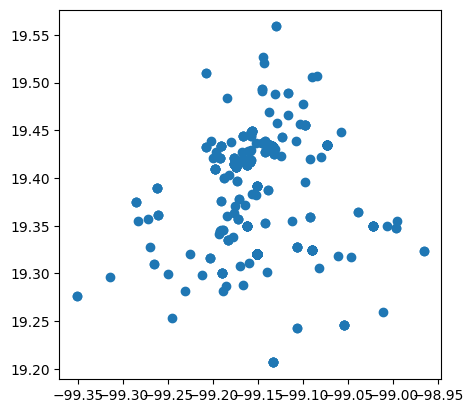

In [62]:
gdf.query(""" ind_found == True""").plot()

In [60]:
# Gold data 

(
    gdf.query(""" ind_found == True and osm_name_label != 'Ciudad de México, México' """)#.to_csv(RAW_DATA + "", index = False)
)

,href,long_description,add_label_used,ind_found,lat,lon,osm_name_label,start_dt,end_dt,date_label,time_label,dt_confidence,time_finder_labels,geometry
3,https://www.tiktok.com/@moniksmr/video/7537785...,Explora el Parque Nacional Los Dinamos en CDMX...,Los Dinamos CDMX,True,19.299869,-99.250028,"Parque Los Dinamos, Pueblo La Magdalena Contre...",,,,,,,POINT (-99.25003 19.29987)
29,https://www.tiktok.com/@xtremepark.mx/video/74...,Xtreme Park: Diversión Ilimitada para Todas la...,"solo $129, Cdmx",True,19.349599,-99.022443,"Calle Árbol Solo, Santa María Aztahuacan, Ciud...",,,,,,,POINT (-99.02244 19.3496)
35,https://www.tiktok.com/@anihii1/video/75906258...,Feria de Revolución en la Alameda CDMX: Divers...,"la Alameda, Cdmx",True,19.449740,-99.156835,"Alameda de Santa Maria La Ribera, Santa María ...",,,,,,,POINT (-99.15684 19.44974)
45,https://www.tiktok.com/@astridzavalam/video/75...,Villa Navideña de Disney Plus en Parque La Mex...,"Parque La Mexicana, Cdmx",True,19.356802,-99.271677,"Parque La Mexicana, 505, Ciudad de México, Cua...",,,,,,,POINT (-99.27168 19.3568)
51,https://www.tiktok.com/@enigma.rooms/video/753...,Vive la Mejor Experiencia en Cuartos de Escape...,"la ciudad, Cdmx",True,19.434235,-99.073312,Aeropuerto Internacional de la Ciudad de Méxic...,,,,,,,POINT (-99.07331 19.43423)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,https://www.tiktok.com/@mariitzaa12/video/7538...,Explore the Dreamiest Experiences in Mexico Ci...,"Mexico City, Cdmx",True,19.432630,-99.133178,"Ciudad de México, Cuauhtémoc, Ciudad de México...",,,,,,,POINT (-99.13318 19.43263)
2849,https://www.tiktok.com/@aide.villarreal29/vide...,Feria en la Alameda Central: Diviértete en CDM...,CDMX. Atracciones,True,19.409133,-99.197918,"Logo CDMX, Avenida Constituyentes, Colonia Amp...",,,,,,,POINT (-99.19792 19.40913)
2855,https://www.tiktok.com/@brvjitaa/video/7589434...,Planos de Arte y Sentimientos en CDMX\nDescubr...,"la ciudad, Cdmx",True,19.434235,-99.073312,Aeropuerto Internacional de la Ciudad de Méxic...,,,,,,,POINT (-99.07331 19.43423)
2859,https://www.tiktok.com/@armageddon.mx/video/75...,Acceso Exclusivo al Evento 360 con Juguete\nÚn...,"Tonalá, Cdmx",True,19.413633,-99.161745,"Tonalá, Calle San Luis Potosí, Roma Norte, Ciu...",,,,,,,POINT (-99.16174 19.41363)


In [63]:
# Save as GeoJSON
(
    gdf
    .query(""" ind_found == True and osm_name_label != 'Ciudad de México, México' """)
    .to_file(
    RAW_DATA + "places_silver_ns.geojson",
    driver="GeoJSON"
    )
)


In [25]:
h = "https://www.tiktok.com/@chuladademaizprieto_/video/7591183128991976712"

driver = webdriver.Chrome()
wait = WebDriverWait(driver, 3)
actions = ActionChains(driver)
keyboard = KeyInput("keyboard")
actions_b = ActionBuilder(driver, keyboard=keyboard)

driver.get(h)

time.sleep(random.uniform(2.5,3.5))

# Expand video description
more_buton = driver.find_element(
    By.CSS_SELECTOR,
    "button[class*='ButtonExpand']"
)

more_buton.click()

time.sleep(random.uniform(2.5,3.5))

# Description extraction
try:
    raw = driver.find_element(
    By.CSS_SELECTOR,
    "div[class*='DivOverlayBottomContent']"
    ).text

    ia_disclaimer = "Esta información se generó por IA y puede presentar resultados que no son relevantes. No representa las opiniones o consejos de TikTok. Si tienes alguna duda, envíanosla a través de: Comentarios y ayuda: TikTok"

    desc_text = raw.replace(ia_disclaimer,"")

except Exception:
    desc_text = ""

time.sleep(random.uniform(0.5,1.5))
driver.quit()

### Data Minning 

In [3]:
results = []


for ht in TAGS_LIST:


    try:
        # Invoke driver object 

        driver = webdriver.Chrome()
        wait = WebDriverWait(driver, 15)
        actions = ActionChains(driver)
        keyboard = KeyInput("keyboard")
        actions_b = ActionBuilder(driver, keyboard=keyboard)


        # Open Main page
        driver.get("https://www.tiktok.com")


        # Look for search icon 
        search_icon = wait.until(EC.presence_of_element_located((
            By.XPATH, "//*[@role='searchbox']"
        )))

        # Put mose in search bar 
        search_icon.click()

        # Input labels 
        actions.send_keys(ht)
        time.sleep(random.uniform(0.05, 0.15))
        actions.perform()

        # Enter to look 
        actions.send_keys("\n")
        actions.perform()

        time.sleep(random.uniform(1.5, 4.5))


        # Getting all inmediate results 
        items = wm.scroll_until_no_new_items(driver)
        wm.scroll_through_elements(driver, items)
        items = driver.find_elements(By.CSS_SELECTOR, "div[id^='grid-item-container-']")

        # Get data from results

        for container in items:
            try:
                href = container.find_element(
                    By.CSS_SELECTOR, "a[href*='/video/']"
                ).get_attribute("href")

                description = container.find_element(
                    By.CSS_SELECTOR, "[data-e2e='new-desc-span']"
                ).text.strip()

                date = container.find_element(
                    By.CSS_SELECTOR, "div[class*='DivTimeTag']"
                ).text.strip()

                results.append({
                    "href": href,
                    "description": description,
                    "date": date,
                    "hashtag_label": ht
                })

            except Exception:
                continue

        print(f"Links search for {ht} ended.")

        driver.quit()

    except:
        driver.quit()



Links search for #dondeircdmx ended.
Links search for #quehacercdmx ended.
Links search for #places #cdmx ended.
Links search for #placescdmx ended.
Links search for #lugaresimperdibles #cdmx ended.
Links search for #lugaressecretoscdmx ended.
Links search for #postres #cdmx ended.
Links search for #evento #cdmx ended.
Links search for #eventoscdmx ended.
Links search for #agendacdmx ended.
Links search for #conciertocdmx ended.
Links search for #festivalcdmx ended.


In [ ]:
df_raw = pd.DataFrame(results)
df_raw['level'] = 0




In [5]:
df_raw.to_csv(RAW_DATA + ROOT_FILE, index = False)

In [ ]:
root_list = df_raw.href.drop_duplicates().to_list()
caption_list = df_raw.description.drop_duplicates().to_list()

desc_results = []

for h, d in zip(root_list, caption_list):

    try:

        driver = webdriver.Chrome()
        wait = WebDriverWait(driver, 15)
        actions = ActionChains(driver)
        keyboard = KeyInput("keyboard")
        actions_b = ActionBuilder(driver, keyboard=keyboard)

        driver.get(h)

        time.sleep(random.uniform(2.5,3.5))

        more_buton = driver.find_element(
            By.CSS_SELECTOR,
            "button[class*='ButtonExpand']"
        )

        more_buton.click()

        time.sleep(random.uniform(2.5,3.5))


        # Date Extraction 
        try:
            raw = driver.find_element(
            By.CSS_SELECTOR,
            "span[class*='StyledTUXText']"
            ).text
            date_text = raw.replace("·","").replace(" ","")
        except Exception:
            date_text = ""

        time.sleep(random.uniform(2.5,3.5))

        # Description extraction
        try:
            raw = driver.find_element(
            By.CSS_SELECTOR,
            "div[class*='DivCustomTDKContainer']"
            ).text

            ia_disclaimer = "Esta información se generó por IA y puede presentar resultados que no son relevantes. No representa las opiniones o consejos de TikTok. Si tienes alguna duda, envíanosla a través de: Comentarios y ayuda: TikTok"

            desc_text = raw.replace(ia_disclaimer,"")

        except Exception:
            desc_text = ""

        time.sleep(random.uniform(0.5,1.5))


        # Get Locations 

         
        try:

            # Get address label

            # From caption 
            if d !='':
                excat_add =  wm.extract_addresses(d, top_k=1, min_score=2.5)
                if len(excat_add) > 0:
                    add_label =  excat_add[0].text
                else:
                    if len(wm.detect_places(d))>0:
                        add_label =  wm.detect_places(d)[0].text
                    else:
                        add_label = ''

            # Fromn text description 
            else:
                if desc_text != "":
                    excat_add =  wm.extract_addresses(desc_text, top_k=1, min_score=2.5)
                    if len(excat_add) > 0:
                        add_label =  excat_add[0].text
                    else:
                        if len(wm.detect_places(desc_text))>0:
                            add_label =  wm.detect_places(d)[0].text
                        else:
                            add_label = ''

                else:
                    add_label = ""

            # Call API if we have label
            if add_label != "":

                loc_osm_api = wm.geocode_osm(add_label)
                
                # Update interest values
                if loc_osm_api["found"]:
                    ind_found = True
                    lat = loc_osm_api["lat"]
                    lon = loc_osm_api["lon"]
                    osm_name_label = loc_osm_api["display_name"]
                    

                else:
                    ind_found = False
                    lat = 0.0
                    lon = 0.0
                    osm_name_label = ""

            # Empty values 
            else: 
                ### [COMPLETE WITH SPEECH TO TEXT OR VIDEO TO TEXT]

                ind_found = False
                lat = 0.0
                lon = 0.0
                osm_name_label = ""

            print(f"Geolocation Process ended for {h}")
                
        # Empty values 
        except:


            ind_found = False
            lat = 0.0
            lon = 0.0
            osm_name_label = ""
            print(f"Geolocation Process Failed for {h}")

        # Update results 
        desc_results.append({
                    "href": h,
                    "long_description": desc_text,
                    "date_long": date_text, 
                    "add_label_used": add_label
                    "ind_found":ind_found, 
                    "lat":lat,
                    "lon":lon, 
                    "osm_name_label":osm_name_label
                                            })

        time.sleep(random.uniform(0.5,1.5))

    # Improve with finally

        driver.quit()

    except:
        driver.quit()

Geolocation Process Failed for https://www.tiktok.com/@moniksmr/video/7545214454246444306
Geolocation Process ended for https://www.tiktok.com/@soymiauoficial/video/7416159212868259078
Geolocation Process ended for https://www.tiktok.com/@sally_qiiu/video/7591718836726975765
Geolocation Process ended for https://www.tiktok.com/@falvindates/video/7589317902264700180
Geolocation Process ended for https://www.tiktok.com/@moniksmr/video/7537785749467401490
Geolocation Process ended for https://www.tiktok.com/@nylagame/video/7591132225698090260
Geolocation Process ended for https://www.tiktok.com/@nylagame/video/7591395230469934357
Geolocation Process ended for https://www.tiktok.com/@nylagame/video/7591679944363740437
Geolocation Process ended for https://www.tiktok.com/@undiacondya/video/7515511709621079314
Geolocation Process ended for https://www.tiktok.com/@moniksmr/video/7572281843647630610
Geolocation Process ended for https://www.tiktok.com/@cocodidany/video/7590571924519013653
Geol

Exception managing chrome: error sending request for url (https://googlechromelabs.github.io/chrome-for-testing/last-known-good-versions-with-downloads.json)
Exception managing chrome: error sending request for url (https://googlechromelabs.github.io/chrome-for-testing/last-known-good-versions-with-downloads.json)
The chromedriver version (143.0.7499.40) detected in PATH at /opt/homebrew/bin/chromedriver might not be compatible with the detected chrome version (); currently, chromedriver  is recommended for chrome .*, so it is advised to delete the driver in PATH and retry
There was an error managing chrome; using browser found in the cache
Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)
Exception managing chrome: error sending request for url (https://googlechromelabs.github.io/chrome-for-testing/last-known-good-versions-with-downloads.json)
Exception managing chrome: error sending request for url (https://googlechromelabs.github.io/chr

In [10]:
df_raw_des = pd.DataFrame(desc_results)

In [11]:
df_raw_des.to_csv(RAW_DATA + DAY_FILE, index = False)

In [18]:
df_raw_des.head(3)

,href,long_description,date_long,ind_found,lat,lon,osm_name_label
0,https://www.tiktok.com/@moniksmr/video/7545214...,Cafeterías Bonitas en la CDMX: Guía para Desay...,2025-9-1,False,0.000000,0.000000,NaN
1,https://www.tiktok.com/@soymiauoficial/video/7...,Parque San Nicolás Totolapan: Un Tesoro en CDM...,2024-9-18,True,19.418492,-99.157634,"Felix, 64, Avenida Álvaro Obregón, Roma Norte,..."
2,https://www.tiktok.com/@sally_qiiu/video/75917...,NaN,Hace13h,False,0.000000,0.000000,NaN


In [12]:
len(df_raw_des)

418

Date and description cleaning 

In [13]:
df_raw = pd.read_csv(RAW_DATA + ROOT_FILE)
df_raw_des = pd.read_csv(RAW_DATA + DAY_FILE)

In [14]:
df = (df_raw.merge(
    df_raw_des
    , on = 'href', how = 'left'
    )
    .dropna(subset=['date_long'])
)

In [17]:
df.head(5)

,href,description,date,hashtag_label,level,long_description,date_long,ind_found,lat,lon,osm_name_label
0,https://www.tiktok.com/@moniksmr/video/7545214...,NaN,NaN,#dondeircdmx,0,Cafeterías Bonitas en la CDMX: Guía para Desay...,2025-9-1,False,0.000000,0.000000,NaN
1,https://www.tiktok.com/@soymiauoficial/video/7...,NaN,NaN,#dondeircdmx,0,Parque San Nicolás Totolapan: Un Tesoro en CDM...,2024-9-18,True,19.418492,-99.157634,"Felix, 64, Avenida Álvaro Obregón, Roma Norte,..."
2,https://www.tiktok.com/@sally_qiiu/video/75917...,NaN,NaN,#dondeircdmx,0,NaN,Hace13h,False,0.000000,0.000000,NaN
3,https://www.tiktok.com/@falvindates/video/7589...,NaN,NaN,#dondeircdmx,0,Disfruta de un día en Acuario Michin en CDMX\n...,2025-12-29,True,19.418492,-99.157634,"Felix, 64, Avenida Álvaro Obregón, Roma Norte,..."
5,https://www.tiktok.com/@moniksmr/video/7537785...,NaN,NaN,#dondeircdmx,0,Explora el Parque Nacional Los Dinamos en CDMX...,2025-8-12,False,0.000000,0.000000,NaN


In [5]:
# Get full description 
df = df.query(""" long_description != '' """)

# Get data 
df.date_long = pd.to_datetime(df.date_long.apply(lambda x: 
                   pd.to_datetime(dt.datetime.today()).strftime('%Y-%m-%d') if 'Hace' in x else x)
                , format='%Y-%m-%d')

date_limit = pd.to_datetime(
    dt.datetime.today()- dt.timedelta(days=DAYS_FRESHNESS)
    ).strftime('%Y-%m-%d')


df = df.query(f""" date_long > '{date_limit}'""")

df = df[~(df.description.isna() & df.long_description.isna())]

df['description'] = df['description'].fillna('')
df['long_description'] = df['long_description'].fillna('')

In [6]:
def get_address(string):
    excat_add =  wm.extract_addresses(string, top_k=1, min_score=2.5)

    if len(excat_add) > 0:
        return wm.extract_addresses(string, top_k=1, min_score=2.5)[0].text
    else:
        if len(wm.detect_places(string)):
            return wm.detect_places(string)[0].text
        else:
            return ''

In [7]:
df["add_long"] = df.long_description.apply(get_address)
df["add_desc"] = df.description.apply(get_address)

In [30]:
df[df.add_desc != '']

,href,description,date,hashtag_label,level,long_description,date_long,add_long,add_desc
91,https://www.tiktok.com/@rivardo24/video/752754...,"Visita el Acuario Michin, el acuario más grand...",2025-7-15,#dondeircdmx,0,"Visita el Acuario Michin en CDMX, el más grand...",2025-07-15,"el Acuario Michin en CDMX, el más grande de La...","el Acuario Michin, el acuario más grande de La..."
92,https://www.tiktok.com/@kar_martinezg/video/75...,¿Cuánto cuesta ir a Six Flags México en Christ...,2025-12-26,#dondeircdmx,0,Precios para disfrutar Christmas In The Park e...,2025-12-26,Six Flags México,Christmas In The Park
94,https://www.tiktok.com/@valpina.mx/video/75173...,Quieres un PLAN DIFERENTE este fin de semana e...,2025-6-18,#dondeircdmx,0,,2025-06-18,,CDMX
95,https://www.tiktok.com/@whattodoinmexicocity/v...,"🎄✨ Navidad mágica en Banjército, CDMX ✨🎄",2025-12-27,#dondeircdmx,0,"Navidad Mágica en Banjército, CDMX: Plan Famil...",2025-12-27,"Banjército, CDMX: Plan Familiar Ideal","Banjército, CDMX ✨🎄"
108,https://www.tiktok.com/@imgabycontre/video/753...,Conoces este lugar? Esta es la Privada Roja en...,2025-7-23,#lugarescdmx,0,,2025-07-23,,CDMX
...,...,...,...,...,...,...,...,...,...
1462,https://www.tiktok.com/@mitikahmall/video/7510...,Restaurantes escondidos en Mítikah,2025-5-30,#restaurantescdmx,0,Descubre Restaurantes Escondidos en Mítikah CD...,2025-05-30,Mítikah CDMX,Mítikah
1467,https://www.tiktok.com/@sisomosgemelos/video/7...,Un buen Restaurante Italiano en CDMX 🍝🍕🇮🇹 📍4 M...,2025-7-4,#restaurantescdmx,0,Descubre 4 Mori: Un Restaurante Italiano en CD...,2025-07-04,CDMX,"📍4 Mori, 3900 Vasco de Quiroga (Sante Fe)"
1474,https://www.tiktok.com/@camaronbuchonmx/video/...,¿Mariscos buenos en CDMX? ¡Claro que si! En el...,2025-11-24,#restaurantescdmx,0,Los mejores mariscos en CDMX: Camarón Buchón\n...,2025-11-24,CDMX: Camarón Buchón,CDMX
1476,https://www.tiktok.com/@soyelarturito/video/75...,"Tacos Charly, CDMX! 🇲🇽🌮 Para muchos el mejor s...",2025-11-2,#restaurantescdmx,0,Tacos Charly: El Mejor Suadero de CDMX\nDescub...,2025-11-02,"CDMX, donde el suadero se convierte en una exp...",Tacos Charly | CDMX


In [23]:
df.loc[1467,'description']

'Un buen Restaurante Italiano en CDMX 🍝🍕🇮🇹 📍4 Mori, 3900 Vasco de Quiroga (Sante Fe)'

In [27]:
wm.extract_addresses(df.loc[1467,'description'], top_k=3, min_score=2.5)

[AddressMatch(text='📍4 Mori, 3900 Vasco de Quiroga (Sante Fe)', span=(42, 83), score=4.0, rule='emoji_soft')]

In [ ]:
df.loc[1467,'href']

'https://www.tiktok.com/@ely_guia/video/7587190357058735378'